<a href="https://colab.research.google.com/github/sayan112207/Stable-Diffusion/blob/main/DeepAlgoAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Feb 17 15:04:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Approach 1: Using a Pre-Trained Stable Diffusion Model

In [2]:
import os
import random
import zipfile
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

##Dataset collection

In [3]:
if not os.path.exists("flickr8k_images"):
    url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
    zip_file = "Flickr8k_Dataset.zip"
    os.system(f"wget {url} -O {zip_file}")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("flickr8k_images")

In [4]:
if not os.path.exists("flickr8k_text"):
    url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    zip_file = "Flickr8k_text.zip"
    os.system(f"wget {url} -O {zip_file}")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("flickr8k_text")

##Dataset Preparation

In [5]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, caption_file, transform=None):
        """
        image_dir: Directory containing Flickr8k images.
        caption_file: Path to the captions file.
        transform: Transformations to apply to images (e.g., resizing).
        """
        self.image_dir = image_dir
        self.transform = transform
        self.captions = {}
        with open(caption_file, 'r') as f:
            for line in f:
                # Each line format:
                # 1000268201_693b08cb0e.jpg#0    A child in a pink dress is climbing up a set of stairs in an entry way .
                parts = line.strip().split('\t')
                if len(parts) < 2:
                    continue
                filename_with_id = parts[0]
                caption = parts[1]
                # Remove the '#<number>' suffix to get the image filename.
                filename = filename_with_id.split('#')[0]
                # Check if the file exists
                if os.path.exists(os.path.join(self.image_dir, filename)):
                    if filename not in self.captions:
                        self.captions[filename] = []
                    self.captions[filename].append(caption)
                else:
                    print(f"Warning: Image file not found: {filename}")  # Print a warning for missing files
        self.image_ids = list(self.captions.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        filename = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")
        # (We also have captions if needed, but here we mainly use the image as filler.)
        caption = random.choice(self.captions[filename])
        if self.transform:
            image = self.transform(image)
        return image, caption

In [6]:
# Define a simple transform for filler images:
filler_transform = transforms.Compose([
    transforms.Resize((256,256))
])

In [7]:
image_dir = "/content/flickr8k_images/Flicker8k_Dataset"
caption_file = "/content/flickr8k_text/Flickr8k.token.txt"

In [8]:
# Create the Flickr8k dataset instance
flickr_dataset = Flickr8kDataset(image_dir, caption_file, transform=filler_transform)

In [9]:
# Example usage: Print out the number of valid images loaded.
print(f"Number of valid images: {len(flickr_dataset)}")

Number of valid images: 8091


In [10]:
# Create a list of filler images (as PIL images) from the dataset.
# We use all available images (or a subset) as filler images.
filler_images = []
for i in range(len(flickr_dataset)):
    img, _ = flickr_dataset[i]
    # img is already a PIL image (resized to 256x256)
    filler_images.append(img)

##Load Stable Diffusion Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/stable-diffusion-v1-4"

In [ ]:
# Load the pipeline with fp16 precision and enable attention slicing to reduce memory usage.
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.enable_attention_slicing()
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)oints%2Fscheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

##Defining Generation Function

In [ ]:
def generate_image(prompt):
    """
    Generate an image based on the text prompt using Stable Diffusion.
    Resize the output to 256x256 for consistency.
    """
    if device == "cuda":
        with torch.autocast("cuda"):
            gen_img = pipe(prompt).images[0]
    else:
        gen_img = pipe(prompt).images[0]
    return gen_img.resize((256, 256))

##Assembling the Grid

In [ ]:
def create_block(prompt, filler_images, border=5):
    """
    Create one 2x2 block (collage) that contains:
      - 1 unique generated image from the text prompt,
      - 3 filler images (sampled randomly).
    A white border (of thickness 'border' in pixels) is added to each image and around the block.

    Returns:
        block: The 2x2 collage as a NumPy array.
        unique_img: The unique (AI-generated) image.
    """
    # Generate the unique image from the prompt.
    unique_img = generate_image(prompt)

    # Randomly select 3 filler images.
    other_imgs = random.sample(filler_images, 3)

    # Combine the images into one list.
    images = [unique_img] + other_imgs
    random.shuffle(images)  # Randomize their order within the block.

    # Convert each image to a NumPy array and add a white border.
    images_with_border = [
        np.pad(np.array(img), ((border, border), (border, border), (0, 0)), mode="constant", constant_values=255)
        for img in images
    ]

    # Arrange into a 2x2 block.
    top_row = np.hstack((images_with_border[0], images_with_border[1]))
    bottom_row = np.hstack((images_with_border[2], images_with_border[3]))
    block = np.vstack((top_row, bottom_row))

    # Add an additional border around the entire block.
    block = np.pad(block, ((border, border), (border, border), (0, 0)), mode="constant", constant_values=255)
    return block, unique_img

In [ ]:
def create_random_grid(prompt, filler_images, num_blocks=16, block_border=5, blocks_per_row=4):
    """
    Create a 4x4 grid (16 blocks) where each block is a 2x2 collage with:
      - 1 generated image (from the prompt) and
      - 3 filler images.

    Returns:
        grid_image: The assembled grid as a NumPy array.
        unique_images: A list of the unique generated images from each block.
    """
    blocks = []
    unique_images = []
    for _ in range(num_blocks):
        block, unique_img = create_block(prompt, filler_images, border=block_border)
        blocks.append(block)
        unique_images.append(unique_img)

    # Arrange blocks into rows.
    rows = []
    for i in range(0, len(blocks), blocks_per_row):
        row = np.hstack(blocks[i:i+blocks_per_row])
        rows.append(row)
    grid_image = np.vstack(rows)
    return grid_image, unique_images

##Displaying the Grid

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

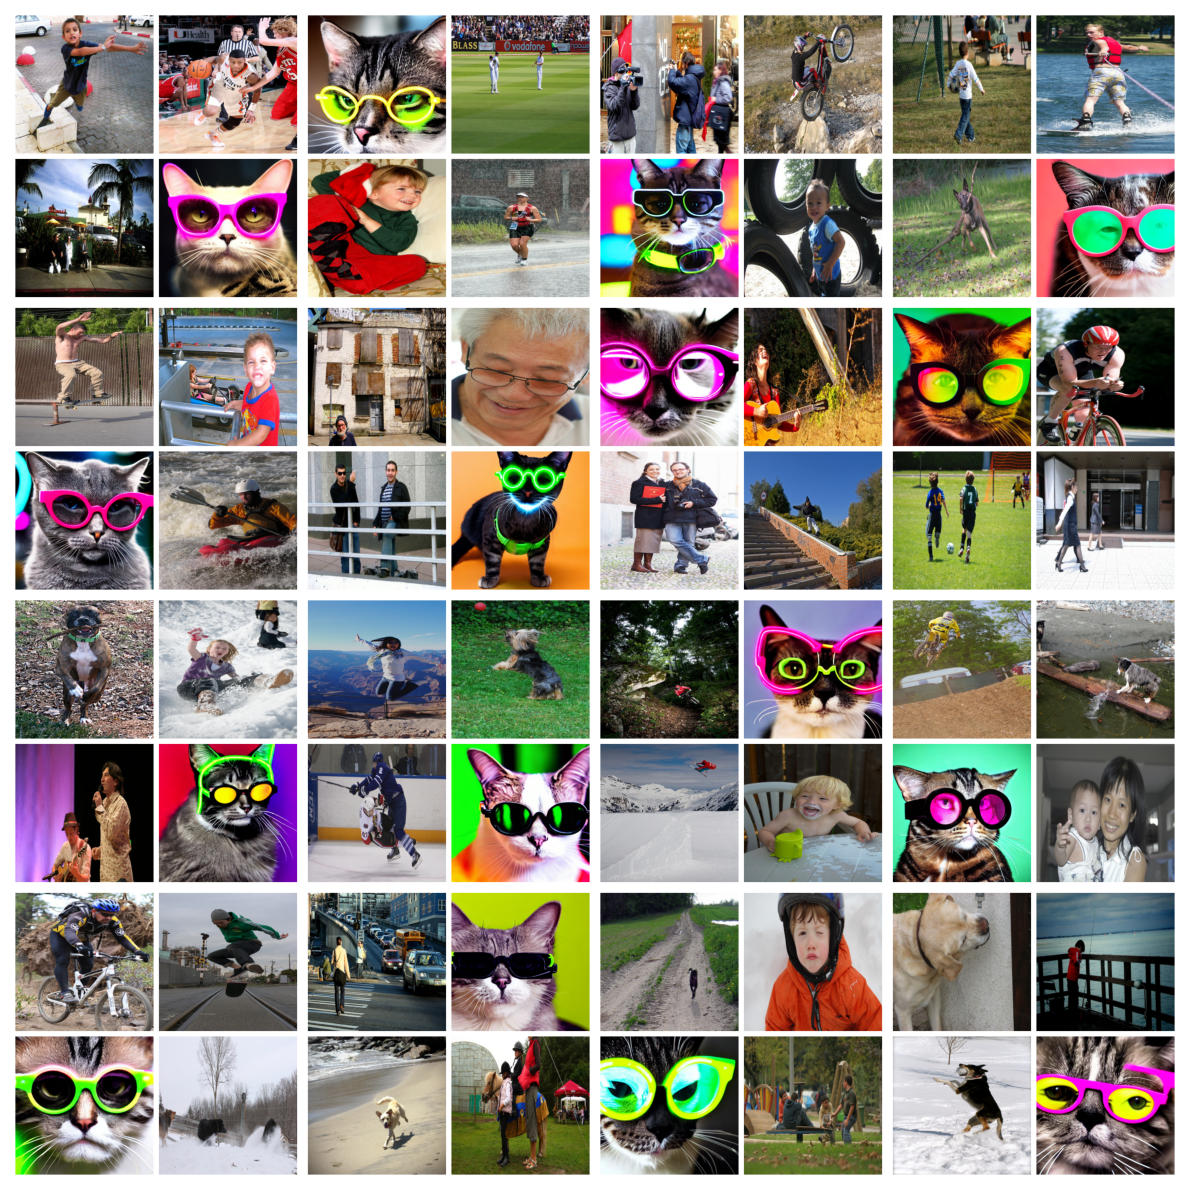

In [ ]:
# Define your prompt.
prompt = "a cat wearing neon-glasses"

# Create the grid of blocks.
grid, unique_images = create_random_grid(prompt, filler_images, num_blocks=16, block_border=5, blocks_per_row=4)

# Display the grid.
plt.figure(figsize=(12, 12))
plt.imshow(grid)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the unique images for evaluation.
output_folder = "generated_unique_images"
os.makedirs(output_folder, exist_ok=True)
for i, img in enumerate(unique_images):
    img.save(os.path.join(output_folder, f"unique_image_{i+1}.png"))

In [ ]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pre-trained CLIP model and processor.
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

output_folder='/content/generated_unique_images'

def compute_clip_score(image_path, text_prompt):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[text_prompt], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    # logits_per_image: similarity between the image and text prompt.
    clip_score = outputs.logits_per_image.item()
    return clip_score

# Compute CLIP Score for each unique image.
clip_scores = []
for filename in os.listdir(output_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(output_folder, filename)
        score = compute_clip_score(image_path, prompt)
        clip_scores.append(score)

if clip_scores:
    average_clip_score = sum(clip_scores) / len(clip_scores)
    print("Average CLIP Score:", average_clip_score)
else:
    print("No images found for CLIP evaluation.")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Average CLIP Score: 36.30697822570801


In [ ]:
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Setup device, model, and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_score_detailed(image_path, text_prompt):
    """
    Compute the CLIP score (cosine similarity) between an image and a text prompt.
    This function prints detailed information including the normalized embeddings.

    Args:
        image_path (str): Path to the generated image.
        text_prompt (str): The text prompt used for generation.

    Returns:
        float: The computed CLIP score (cosine similarity).
    """
    # Load the image and convert it to RGB.
    image = Image.open(image_path).convert("RGB")

    # Preprocess both the image and the text prompt.
    inputs = clip_processor(text=[text_prompt], images=image, return_tensors="pt", padding=True).to(device)

    image_features = clip_model.get_image_features(pixel_values=inputs.pixel_values)

    text_features = clip_model.get_text_features(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask)

    # Normalize the features (this is important for cosine similarity).
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    cosine_similarity = F.cosine_similarity(image_features, text_features).item()

    return cosine_similarity

score = compute_clip_score_detailed("/content/generated_unique_images/unique_image_1.png", "a cat wearing neon-glasses")
print("CLIP Score: ",score)

CLIP Score:  0.3500049114227295


In [ ]:
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Setup device, model, and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_score_detailed(image, text_prompt):
    """
    Compute the CLIP score (cosine similarity) between an image and a text prompt.

    Args:
        image (PIL.Image.Image): The generated image.
        text_prompt (str): The text prompt used for generation.

    Returns:
        float: The computed CLIP score (cosine similarity).
    """
    # Preprocess both the image and the text prompt.
    inputs = clip_processor(text=[text_prompt], images=image, return_tensors="pt", padding=True).to(device)

    image_features = clip_model.get_image_features(pixel_values=inputs.pixel_values)
    text_features = clip_model.get_text_features(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask)

    # Normalize the features for cosine similarity.
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    cosine_similarity = F.cosine_similarity(image_features, text_features).item()

    return cosine_similarity

In [ ]:
# List of three different prompts.
prompts = [
    "a cat wearing neon-glasses",
    "a futuristic city at sunset",
    "a majestic mountain landscape"
]

# Generate one image per prompt.
generated_images = [generate_image(prompt) for prompt in prompts]

# Compute the 3x3 CLIP similarity matrix.
import numpy as np # Make sure numpy is imported
similarity_matrix = np.zeros((len(generated_images), len(prompts)))
for i, gen_img in enumerate(generated_images):
    for j, text_prompt in enumerate(prompts):
        # Pass the gen_img (PIL Image) directly
        similarity_matrix[i, j] = compute_clip_score_detailed(gen_img, text_prompt)

print("CLIP Similarity Matrix (rows: generated images, columns: text prompts):")
print(similarity_matrix)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Similarity Matrix (rows: generated images, columns: text prompts):
[[0.35707539 0.13564426 0.19284821]
 [0.1946954  0.33658695 0.22969005]
 [0.08894372 0.18207932 0.28138137]]


#Approach 2: Using a Fine-Tuned Stable Diffusion Model

In [11]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set device.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# -----------------------------
# 1. Load the Stable Diffusion Pipeline with your Adapter
# -----------------------------
from diffusers import StableDiffusionPipeline
from transformers import AutoTokenizer
from peft import PeftModel

def load_pipeline_with_adapter(adapter_dir="/content/LORA Model"):
    """
    Load a stable diffusion pipeline (runwayml/stable-diffusion-v1-5) and
    replace its UNet with your trained adapter from the given folder.
    """
    model_id = "runwayml/stable-diffusion-v1-5"
    pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16
    ).to(device)

    # Ensure tokenizer exists.
    if pipe.tokenizer is None:
        pipe.tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Replace UNet with your adapter.
    pipe.unet = PeftModel.from_pretrained(pipe.unet, adapter_dir)
    # Merge the LoRA weights into the base model for inference.
    pipe.unet = pipe.unet.merge_and_unload()
    return pipe

# Create a global pipeline.
pipe = load_pipeline_with_adapter("/content/LORA Model")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.tran

In [13]:
# -----------------------------
# 2. Define Image Generation Functions
# -----------------------------
def generate_image(prompt):
    """
    Generate an image based on the text prompt using the loaded pipeline.
    The output is resized to 256x256.
    """
    # Append style modifications to the user prompt.
    full_prompt = f"{prompt}, impressionist style converted to pencil drawing, detailed graphite art, intricate shading"

    if device == "cuda":
        with torch.autocast("cuda"):
            gen_img = pipe(full_prompt).images[0]
    else:
        gen_img = pipe(full_prompt).images[0]
    return gen_img.resize((256, 256))

def create_block(prompt, filler_images, border=5):
    """
    Create a 2x2 collage block that contains:
      - 1 unique generated image from the prompt,
      - 3 filler images (sampled randomly from filler_images).
    Each image gets a white border (thickness 'border' pixels), and an
    extra border is added around the block.

    Returns:
        block: The 2x2 collage as a NumPy array.
        unique_img: The unique generated image.
    """
    # Generate the unique image.
    unique_img = generate_image(prompt)

    # Randomly select 3 filler images.
    other_imgs = random.sample(filler_images, 3)

    # Combine and randomize the order.
    images = [unique_img] + other_imgs
    random.shuffle(images)

    # Convert each image to a NumPy array and add a white border.
    images_with_border = [
        np.pad(np.array(img), ((border, border), (border, border), (0, 0)),
               mode="constant", constant_values=255)
        for img in images
    ]

    # Create the 2x2 block.
    top_row = np.hstack((images_with_border[0], images_with_border[1]))
    bottom_row = np.hstack((images_with_border[2], images_with_border[3]))
    block = np.vstack((top_row, bottom_row))

    # Add an outer border.
    block = np.pad(block, ((border, border), (border, border), (0, 0)),
                   mode="constant", constant_values=255)
    return block, unique_img

def create_random_grid(prompt, filler_images, num_blocks=16, block_border=5, blocks_per_row=4):
    """
    Assemble a grid of collage blocks. Each block is created as a 2x2 collage
    that contains one unique AI-generated image (from the prompt) and three filler images.

    Returns:
        grid_image: The assembled grid as a NumPy array.
        unique_images: A list of all the unique generated images (one per block).
    """
    blocks = []
    unique_images = []
    for _ in range(num_blocks):
        block, unique_img = create_block(prompt, filler_images, border=block_border)
        blocks.append(block)
        unique_images.append(unique_img)

    # Arrange blocks into rows.
    rows = []
    for i in range(0, len(blocks), blocks_per_row):
        row = np.hstack(blocks[i:i+blocks_per_row])
        rows.append(row)
    grid_image = np.vstack(rows)
    return grid_image, unique_images

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

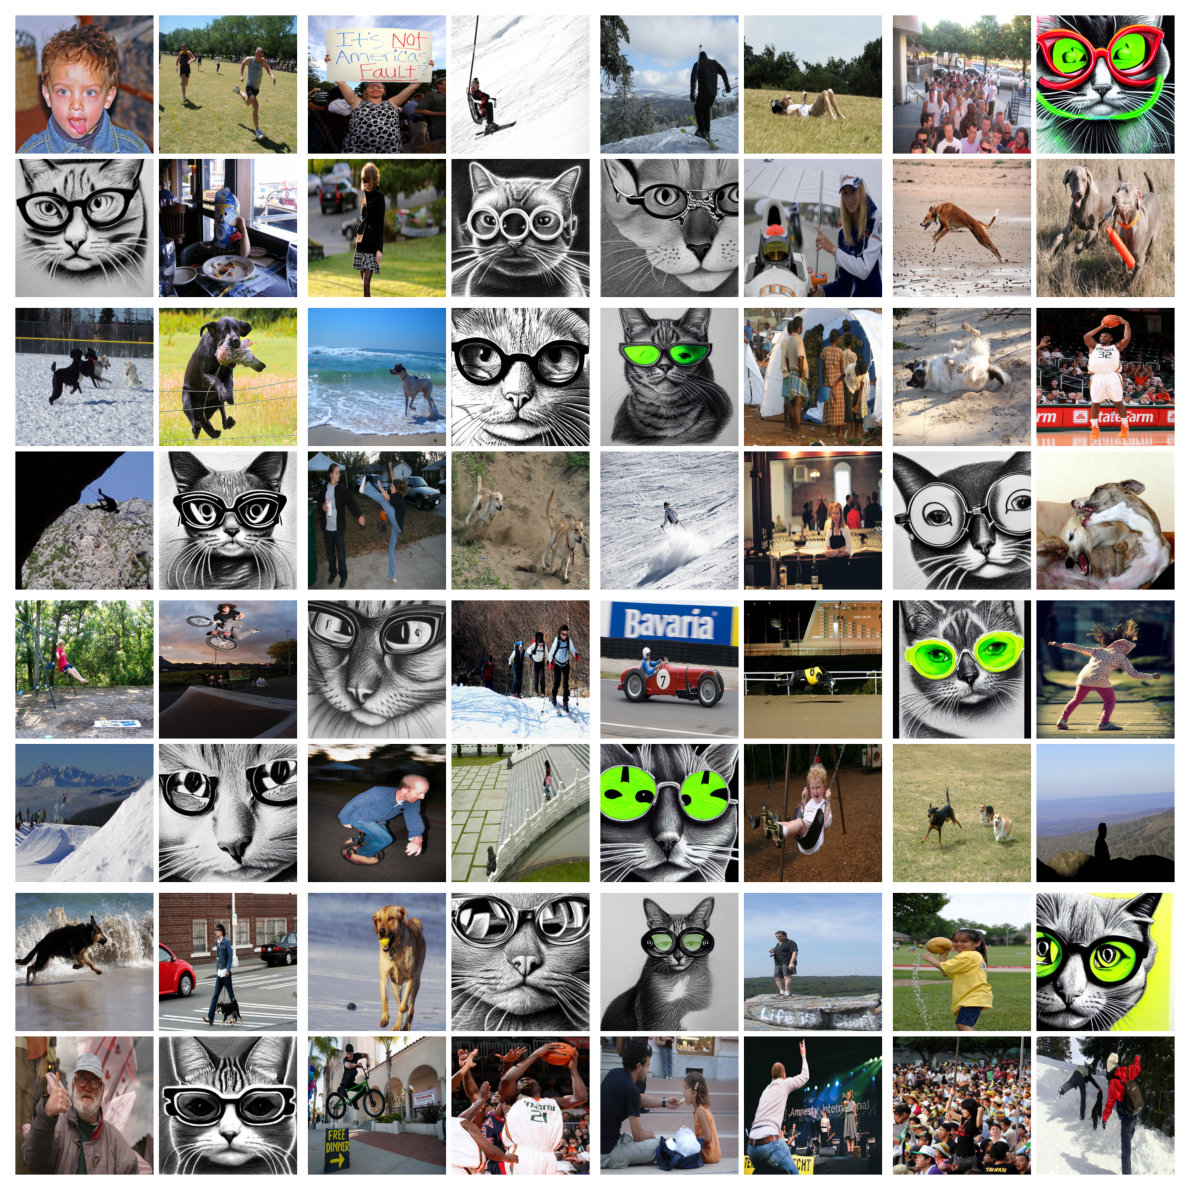

Unique images saved in '/content/generated_unique_images_with_trained_model' folder.


In [14]:
# -----------------------------
# 4. Generate the Grid and Display It
# -----------------------------
# Define your prompt.
prompt_text = "a cat wearing neon-glasses"

# Create the grid (e.g., 16 blocks arranged 4 per row).
grid, unique_images = create_random_grid(prompt_text, filler_images, num_blocks=16, block_border=5, blocks_per_row=4)

# Display the grid in Colab.
plt.figure(figsize=(12, 12))
plt.imshow(grid)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the unique images in a separate folder.
output_folder = "/content/generated_unique_images_with_trained_model"
os.makedirs(output_folder, exist_ok=True)
for i, img in enumerate(unique_images):
    img.save(os.path.join(output_folder, f"unique_image_{i+1}.png"))
print(f"Unique images saved in '{output_folder}' folder.")

In [16]:
# -----------------------------
# 5. Compute CLIP Scores for the Unique Images
# -----------------------------
from transformers import CLIPProcessor, CLIPModel

# Load pre-trained CLIP model and processor.
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_score(image_path, text_prompt):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[text_prompt], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    # The CLIP score is given by logits_per_image.
    clip_score = outputs.logits_per_image.item()
    return clip_score

# Evaluate each unique image.
clip_scores = []
for filename in os.listdir(output_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(output_folder, filename)
        score = compute_clip_score(image_path, prompt_text)
        clip_scores.append(score)

if clip_scores:
    average_clip_score = sum(clip_scores) / len(clip_scores)
    print("Average CLIP Score:", average_clip_score)
else:
    print("No images found for CLIP evaluation.")

Average CLIP Score: 31.1378390789032


In [20]:
new_prompt = "a cat wearing neon glasses with impressionism style artwork in pencil-sketch"
# Evaluate each unique image.
clip_scores = []
for filename in os.listdir(output_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(output_folder, filename)
        score = compute_clip_score(image_path, new_prompt)
        clip_scores.append(score)

if clip_scores:
    average_clip_score = sum(clip_scores) / len(clip_scores)
    print("Average CLIP Score:", average_clip_score)
else:
    print("No images found for CLIP evaluation.")

Average CLIP Score: 34.908650279045105
